# Descriptions
This project assignment is inspired by investigation conducted in (Bolón-Canedo et. al. 2012). The goal of the experiment is to evaluate various feature selection methods on synthetic data sets with known important and redundant attributes. The experiment that you will conduct includes following steps.
##  Generate synthetic data
Propose method that will allow you to generate a synthetic data sets for binary classification purpose.
- The set should contain small number of relevant features.
- Then, increase the dimension of the data by adding irrelevant features, redundant features, correlated features, noisy features etc. 
- The important thing here is for you to keep the information about which variables are relevant to the classification task.

You can use or incorporate ready-made implementations of the data generator for classification task e.g. make_classification from sklearn. But include the short explanation of the data generation process that this function uses in your final presentation. You may assume that classes in your set are balanced.

In [1]:
# add parent directory to path
import sys
import os

# Get the absolute path of the notebook's directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# Get the parent directory (project root)
project_root = os.path.dirname(notebook_dir)

# Add the project root to Python path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline

# Make text bigger on plots
plt.rcParams.update({
    'font.size': 14,             # Base font size (you already have this)
    'axes.titlesize': 16,        # Title font size
    'figure.titlesize': 18       # Figure title font size
})

Added c:\Users\Łukasz\OneDrive - Politechnika Warszawska\MINI_1D\Semestr 8\Data Viz\Project\DataViz\Task1 to Python path


# Genertation

In [ ]:
n_features = 85  # Total number of features from the original dataset
n_informative = 5  # Number of informative features
n_redundant = 20  # Number of redundant features
n_noise = n_features - n_informative - n_redundant  # Number of noise features

X_base, y = make_classification(
    n_samples=1000,          # Number of samples
    n_features=n_features,            # Total features
    n_informative=n_informative,         # Relevant features
    n_redundant=n_redundant,           # Redundant features 
    n_repeated=0,            # Repeated features
    n_classes=2,             # Binary classification
    random_state=42,         # For reproducibility
    class_sep=1.0,            # Class separation (default)
    shuffle=False          # Do not shuffle the data
)

X_df = pd.DataFrame(X_base, columns=[f'feature_{i}' for i in range(X_base.shape[1])])
y_df = pd.Series(y, name='target')

display(X_df.head())
display(y_df.head())

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84
0,0.398925,0.300726,-1.242678,-2.660669,0.742052,-3.352542,-2.115725,2.355648,-0.416028,0.848956,...,1.120848,-0.524283,0.598330,-1.724917,-0.686936,1.392655,-0.385037,-1.868002,2.013699,0.562250
1,0.126402,-0.118903,1.683483,0.544816,1.466724,1.380566,1.910257,-1.051895,1.278274,-2.639946,...,-1.005520,-0.976246,-0.297057,-0.300872,0.911832,-0.668876,0.435078,-0.305470,-0.744757,-0.330376
2,0.307531,1.477413,1.206126,-0.903038,0.553739,-1.292537,0.878660,-1.357008,-1.000782,-0.564504,...,0.642657,0.804256,-1.838777,-0.814718,1.071965,-0.718039,-0.111491,1.441805,-0.361577,-0.504719
3,1.078409,0.919532,0.589260,-1.545148,0.857398,-1.537698,0.705814,-0.326711,-0.074777,-1.166851,...,0.305564,-1.253805,0.003975,0.592478,0.208055,-0.723131,0.908812,-0.407971,-1.334161,-0.283728
4,0.464995,3.919686,4.381151,-0.868213,-1.112734,-1.005722,3.929205,-5.457908,-4.013074,-0.742072,...,1.999240,1.139975,-0.101558,-0.482272,1.338027,1.007581,-1.410427,1.085821,-0.154374,-0.860912


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [3]:
informative_features = X_base[:, :5]  # First 5 columns are informative

# Create correlated features
n_correlated = 15
correlated_features = np.zeros((X_base.shape[0], n_correlated))
correlation_values = []

# For each correlated feature, base it on one of the informative features
for i in range(n_correlated):
    # Select a random informative feature to correlate with
    base_feature_idx = np.random.randint(0, 5)
    base_feature = informative_features[:, base_feature_idx]
    
    # Randomly choose whether correlation will be positive or negative
    if np.random.random() < 0.5:
        # Positive strong correlation (0.7 to 1.0)
        correlation_strength = 0.7 + (0.3 * np.random.random())
    else:
        # Negative strong correlation (-1.0 to -0.7)
        correlation_strength = -1.0 + (0.3 * np.random.random())

    correlation_values.append({
        'correlated_feature': f'correlated_{i}',
        'base_feature': f'feature_{base_feature_idx}',
        'correlation_strength': correlation_strength
    })

    noise_level = np.sqrt(1 - correlation_strength**2)
    
    # Generate the correlated feature
    noise = np.random.normal(0, 1, size=len(base_feature))
    correlated_feature = correlation_strength * base_feature + noise_level * noise
    
    # Standardize to maintain similar scale
    correlated_features[:, i] = StandardScaler().fit_transform(correlated_feature.reshape(-1, 1)).flatten()

# Add the correlated features to X_base
X_with_correlated = np.hstack((X_base, correlated_features))

# Create DataFrame with all features
feature_names = [f'feature_{i}' for i in range(X_base.shape[1])]
correlated_names = [f'correlated_{i}' for i in range(n_correlated)]
X_full_df = pd.DataFrame(
    X_with_correlated, 
    columns=feature_names + correlated_names
)
display(X_full_df.head())

# Create a DataFrame with correlation information for reference
correlation_info = pd.DataFrame(correlation_values)
display(correlation_info)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,correlated_5,correlated_6,correlated_7,correlated_8,correlated_9,correlated_10,correlated_11,correlated_12,correlated_13,correlated_14
0,0.398925,0.300726,-1.242678,-2.660669,0.742052,-3.352542,-2.115725,2.355648,-0.416028,0.848956,...,-0.137215,0.144527,-1.364778,-0.513251,-0.247230,-0.635104,-0.070881,0.126649,-1.390159,-1.406479
1,0.126402,-0.118903,1.683483,0.544816,1.466724,1.380566,1.910257,-1.051895,1.278274,-2.639946,...,0.285149,0.655642,0.783375,-0.636475,-0.686044,0.124363,0.331438,-0.088910,0.826027,0.594635
2,0.307531,1.477413,1.206126,-0.903038,0.553739,-1.292537,0.878660,-1.357008,-1.000782,-0.564504,...,-0.696154,0.006327,-0.283703,0.303016,0.725250,0.440799,0.223597,0.176324,-0.314903,-0.251584
3,1.078409,0.919532,0.589260,-1.545148,0.857398,-1.537698,0.705814,-0.326711,-0.074777,-1.166851,...,-0.161355,0.325564,-0.884499,-0.309968,0.119979,-0.413432,0.121688,-0.018194,-0.828054,-0.797289
4,0.464995,3.919686,4.381151,-0.868213,-1.112734,-1.005722,3.929205,-5.457908,-4.013074,-0.742072,...,-1.956791,-0.976473,-0.353033,1.119918,1.142369,2.089168,-1.296591,-0.188656,-0.433651,-0.278541


,correlated_feature,base_feature,correlation_strength
0,correlated_0,feature_3,0.894698
1,correlated_1,feature_3,0.978876
2,correlated_2,feature_1,0.706580
3,correlated_3,feature_2,0.763767
4,correlated_4,feature_0,-0.977346
5,correlated_5,feature_1,-0.842091
6,correlated_6,feature_4,0.996289
7,correlated_7,feature_3,0.819989
8,correlated_8,feature_4,-0.810762
9,correlated_9,feature_1,0.770220


In [4]:
# Rename features with more descriptive names while preserving original numbering
feature_mapping = {}

# Informative/Relevant features (first 5)
for i in range(5):
    old_name = f'feature_{i}'
    new_name = f'informative_{i}'
    feature_mapping[old_name] = new_name

# Redundant features (next 40)
for i in range(5, 45):
    old_name = f'feature_{i}'
    new_name = f'redundant_{i}'  # Keep original index to maintain order
    feature_mapping[old_name] = new_name

# Noise features (remaining original features)
for i in range(45, 85):
    old_name = f'feature_{i}'
    new_name = f'noise_{i}'  # Keep original index to maintain order
    feature_mapping[old_name] = new_name

# Correlated features - start numbering from after the last noise feature (85)
for i in range(n_correlated):
    old_name = f'correlated_{i}'
    base_feature_idx = correlation_info.loc[i, 'base_feature'].split('_')[1]
    new_name = f'correlated_{i+n_features}_to_{base_feature_idx}'  # Start numbering from 85
    feature_mapping[old_name] = new_name

# Rename the columns in the dataframe
X_full_df = X_full_df.rename(columns=feature_mapping)

# Update the correlation info dataframe with new feature names
for i in range(len(correlation_info)):
    old_base = correlation_info.loc[i, 'base_feature']
    if old_base in feature_mapping:
        correlation_info.loc[i, 'base_feature'] = feature_mapping[old_base]
    
    old_correlated = correlation_info.loc[i, 'correlated_feature']
    if old_correlated in feature_mapping:
        correlation_info.loc[i, 'correlated_feature'] = feature_mapping[old_correlated]

# Display the first few rows with the new column names
display(X_full_df.head())
display(correlation_info.head())

# Create a dataframe summarizing the feature types
feature_summary = pd.DataFrame([
    {'Type': 'Informative', 'Count': n_informative, 'Index Range': f'0-{n_informative-1}', 'Description': 'Original informative features'},
    {'Type': 'Redundant', 'Count': n_redundant, 'Index Range': f'{n_informative}-{n_informative+n_redundant-1}', 'Description': 'Features derived from informative ones but less directly relevant'},
    {'Type': 'Noise', 'Count': n_noise, 'Index Range': f'{n_informative+n_redundant}-{n_features-1}', 'Description': 'Random noise features with little to no correlation to target'},
    {'Type': 'Correlated', 'Count': n_correlated, 'Index Range': f'{n_features}-{n_features+n_correlated-1}', 'Description': 'Features with strong correlation to specific informative features'}
])

display(feature_summary)

# Print the total number of features
print(f"Total number of features: {X_full_df.shape[1]}")

,informative_0,informative_1,informative_2,informative_3,informative_4,redundant_5,redundant_6,redundant_7,redundant_8,redundant_9,...,correlated_90_to_1,correlated_91_to_4,correlated_92_to_3,correlated_93_to_4,correlated_94_to_1,correlated_95_to_2,correlated_96_to_4,correlated_97_to_0,correlated_98_to_3,correlated_99_to_3
0,0.398925,0.300726,-1.242678,-2.660669,0.742052,-3.352542,-2.115725,2.355648,-0.416028,0.848956,...,-0.137215,0.144527,-1.364778,-0.513251,-0.247230,-0.635104,-0.070881,0.126649,-1.390159,-1.406479
1,0.126402,-0.118903,1.683483,0.544816,1.466724,1.380566,1.910257,-1.051895,1.278274,-2.639946,...,0.285149,0.655642,0.783375,-0.636475,-0.686044,0.124363,0.331438,-0.088910,0.826027,0.594635
2,0.307531,1.477413,1.206126,-0.903038,0.553739,-1.292537,0.878660,-1.357008,-1.000782,-0.564504,...,-0.696154,0.006327,-0.283703,0.303016,0.725250,0.440799,0.223597,0.176324,-0.314903,-0.251584
3,1.078409,0.919532,0.589260,-1.545148,0.857398,-1.537698,0.705814,-0.326711,-0.074777,-1.166851,...,-0.161355,0.325564,-0.884499,-0.309968,0.119979,-0.413432,0.121688,-0.018194,-0.828054,-0.797289
4,0.464995,3.919686,4.381151,-0.868213,-1.112734,-1.005722,3.929205,-5.457908,-4.013074,-0.742072,...,-1.956791,-0.976473,-0.353033,1.119918,1.142369,2.089168,-1.296591,-0.188656,-0.433651,-0.278541


,correlated_feature,base_feature,correlation_strength
0,correlated_85_to_3,informative_3,0.894698
1,correlated_86_to_3,informative_3,0.978876
2,correlated_87_to_1,informative_1,0.706580
3,correlated_88_to_2,informative_2,0.763767
4,correlated_89_to_0,informative_0,-0.977346


,Type,Count,Index Range,Description
0,Informative,5,0-4,Original informative features
1,Redundant,40,5-44,Features derived from informative ones but les...
2,Noise,40,45-84,Random noise features with little to no correl...
3,Correlated,15,85-99,Features with strong correlation to specific i...


Total number of features: 100


# Vizualizations
## 1. Scatter plots between informative features and their correlated counterparts

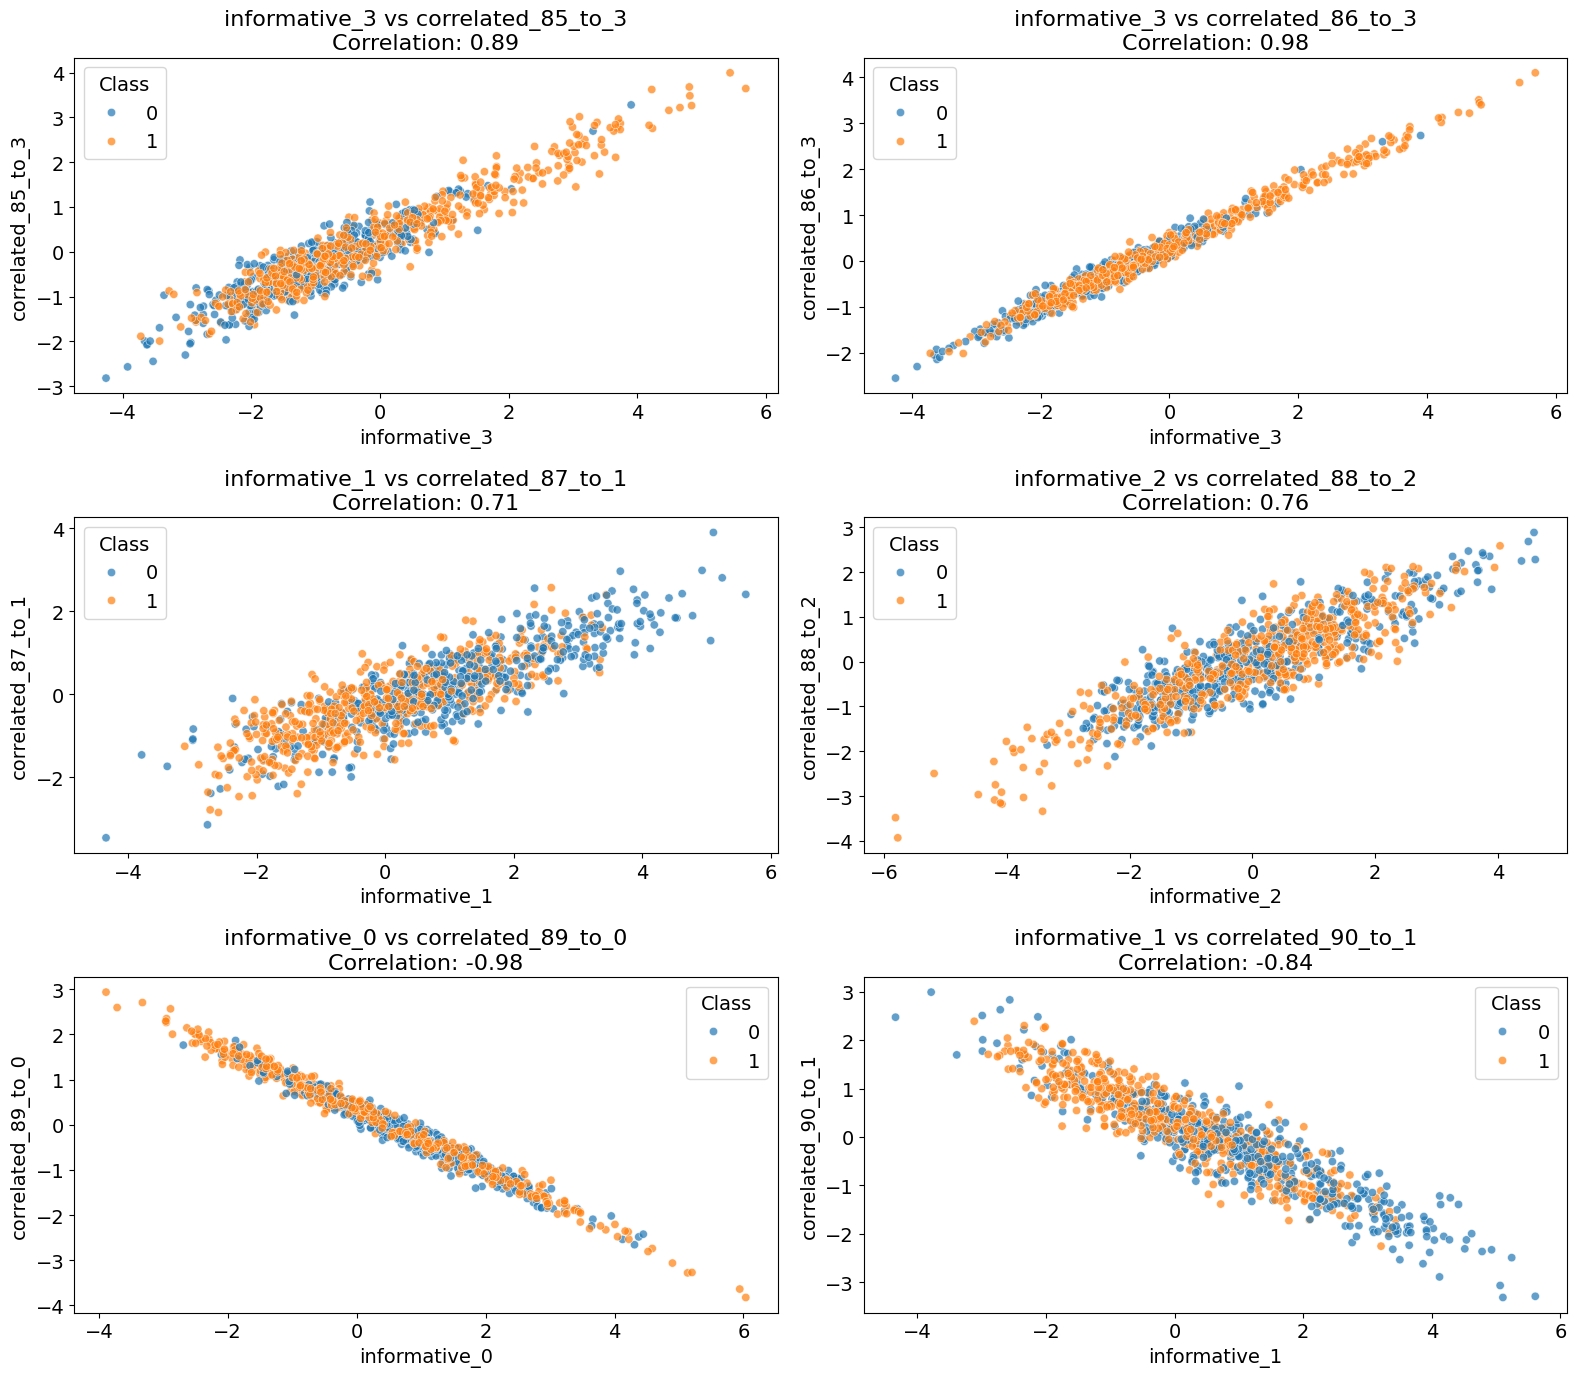

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

# Select a few interesting correlations to plot
samples = min(6, len(correlation_info))
for i in range(samples):
    # Get the correlation information
    info = correlation_info.iloc[i]
    base_feature = info['base_feature']
    corr_feature = info['correlated_feature']
    corr_strength = info['correlation_strength']
    
    # Create the scatter plot
    ax = axes[i]
    sns.scatterplot(
        x=X_full_df[base_feature], 
        y=X_full_df[corr_feature],
        hue=y_df,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"{base_feature} vs {corr_feature}\nCorrelation: {corr_strength:.2f}")
    ax.set_xlabel(base_feature)
    ax.set_ylabel(corr_feature)
    ax.legend(title='Class')

plt.tight_layout()
plt.show()

## 2. Correlation heatmap

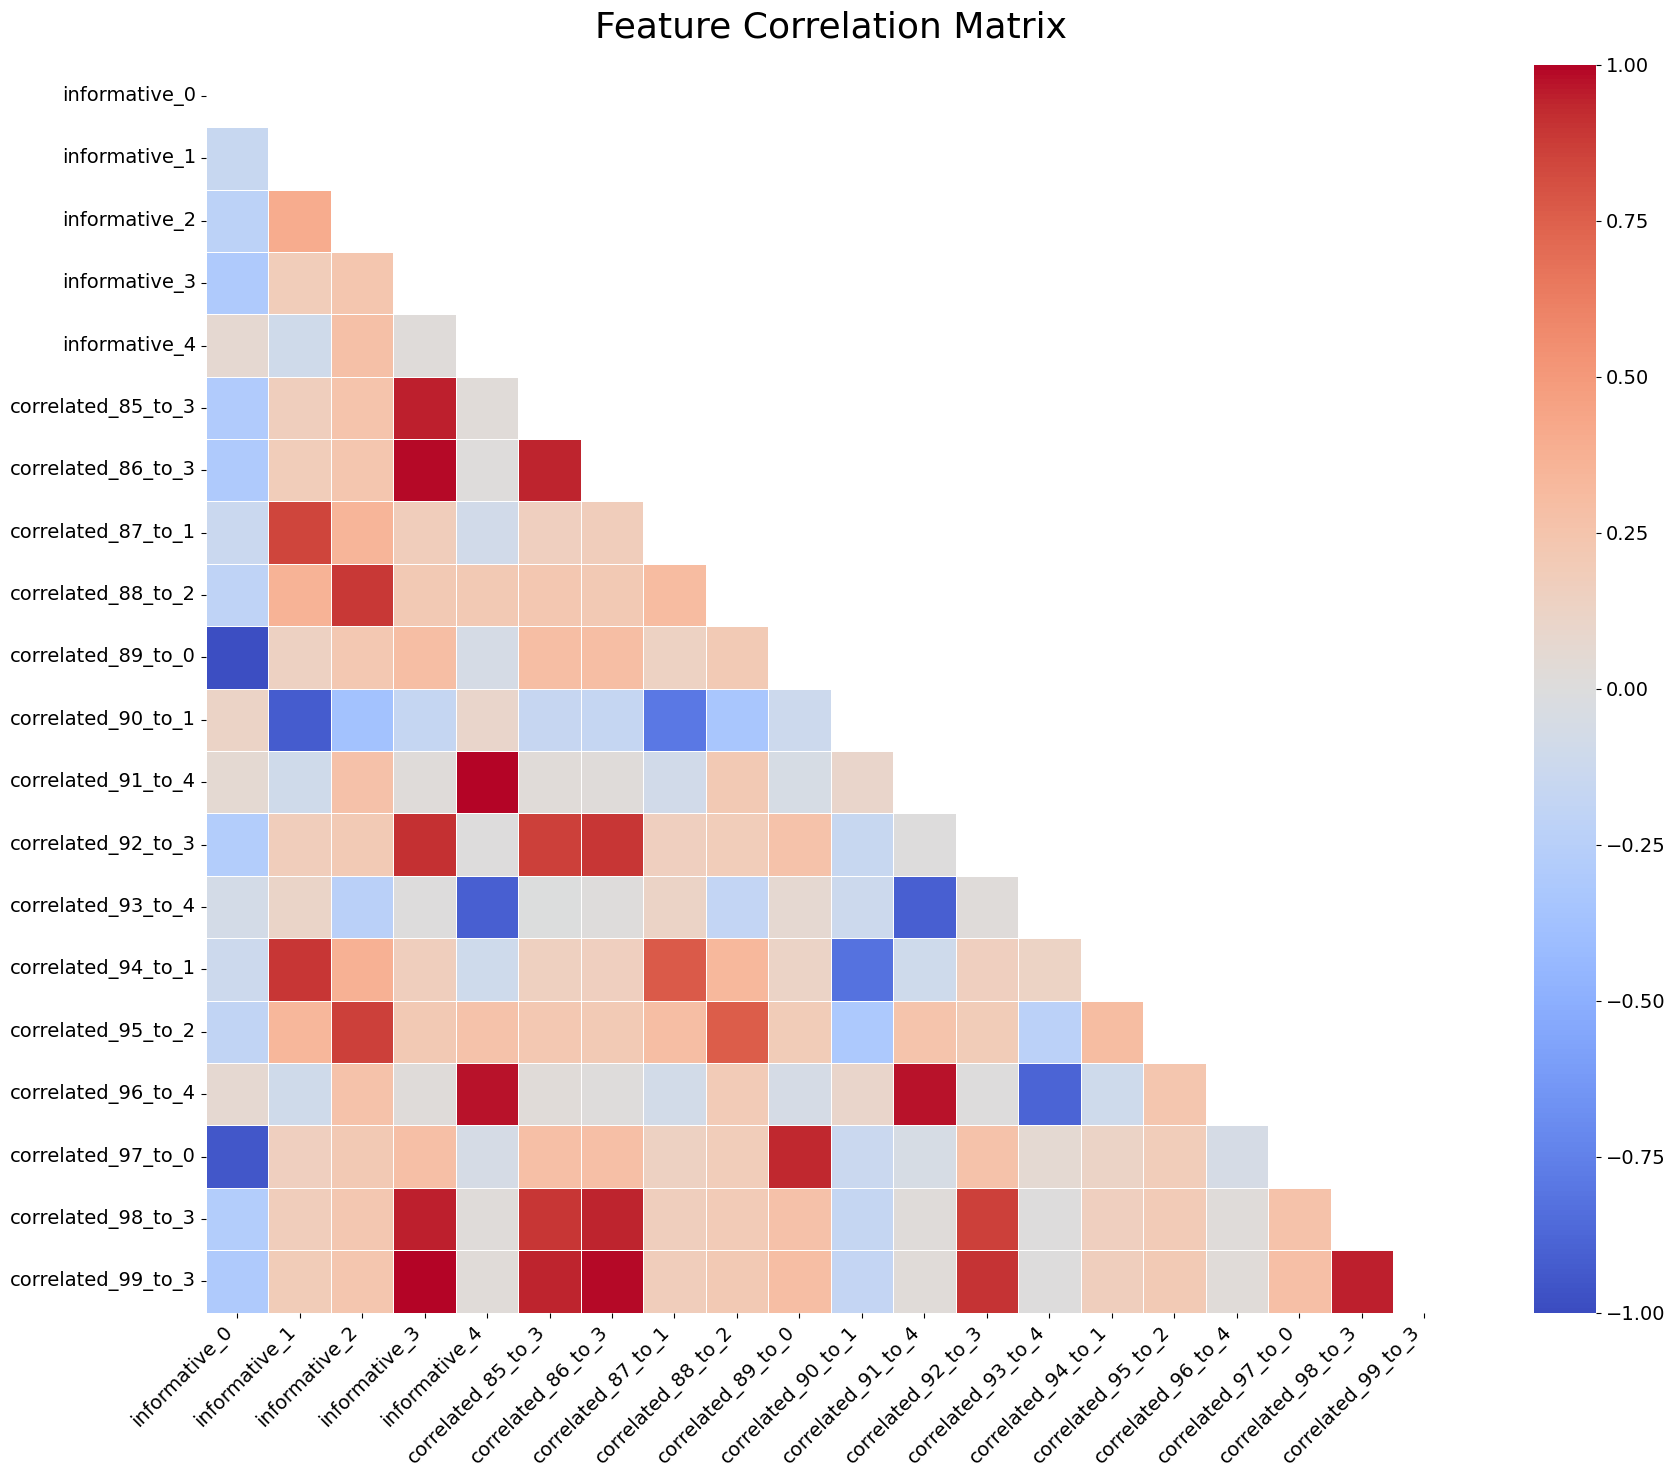

In [6]:
plt.figure(figsize=(18, 15))

# Select informative features and their correlated features
informative_cols = [f'informative_{i}' for i in range(n_informative)]

# Select columns for the heatmap - first put informative features in order
selected_cols = informative_cols.copy()  # Start with informative cols in numerical order

# Then add correlated features
correlated_features = list(correlation_info['correlated_feature'])
selected_cols.extend(correlated_features)

# Calculate correlation matrix for selected columns
corr_matrix = X_full_df[selected_cols].corr()

# Create heatmap with annotations
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask the upper triangle

sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap='coolwarm',
    mask=mask,
    vmin=-1, 
    vmax=1,
    linewidths=0.5
)

plt.title("Feature Correlation Matrix", fontsize=26, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_24620\3299119115.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_24620\3299119115.py:20: UserWarning: The palette list has more values (100) than needed (30), which may not be intended.
  sns.barplot(


<Figure size 1400x600 with 0 Axes>

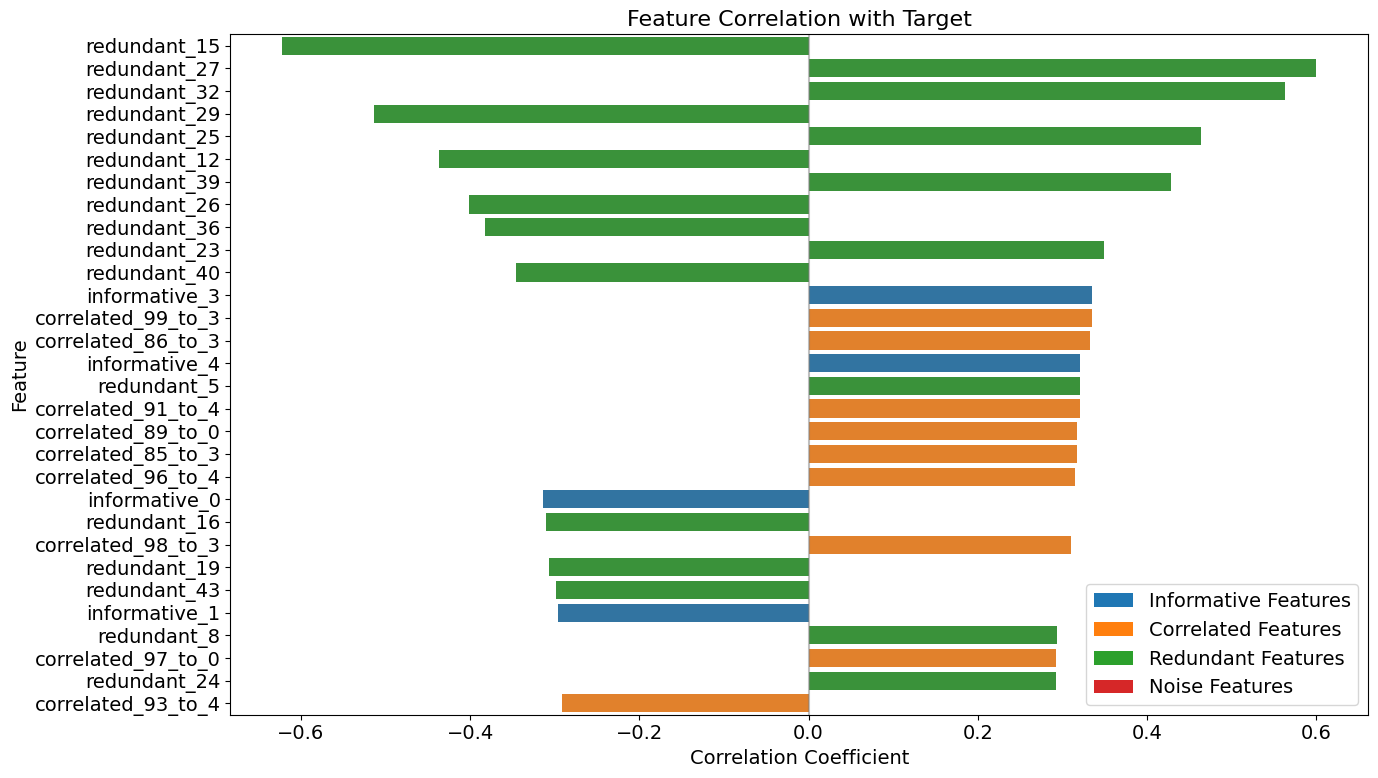

In [7]:
# 3. Additional visualization: Feature correlations with target
plt.figure(figsize=(14, 6))

# Calculate correlation with target for each feature
target_correlations = []
for col in X_full_df.columns:
    corr = np.corrcoef(X_full_df[col], y_df)[0, 1]
    target_correlations.append({'feature': col, 'correlation': corr})

target_corr_df = pd.DataFrame(target_correlations)
target_corr_df = target_corr_df.sort_values('correlation', key=abs, ascending=False)

# Highlight different feature types by their prefix
colors = ['#1f77b4' if 'informative_' in f else 
          '#ff7f0e' if 'correlated_' in f else 
          '#2ca02c' if 'redundant_' in f else 
          '#d62728' for f in target_corr_df['feature']]

plt.figure(figsize=(14, 8))
sns.barplot(
    x='correlation',
    y='feature',
    data=target_corr_df.head(30),  # Top 30 features by absolute correlation
    palette=colors
)

plt.title('Feature Correlation with Target')
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='Informative Features'),
    Patch(facecolor='#ff7f0e', label='Correlated Features'),
    Patch(facecolor='#2ca02c', label='Redundant Features'),
    Patch(facecolor='#d62728', label='Noise Features')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

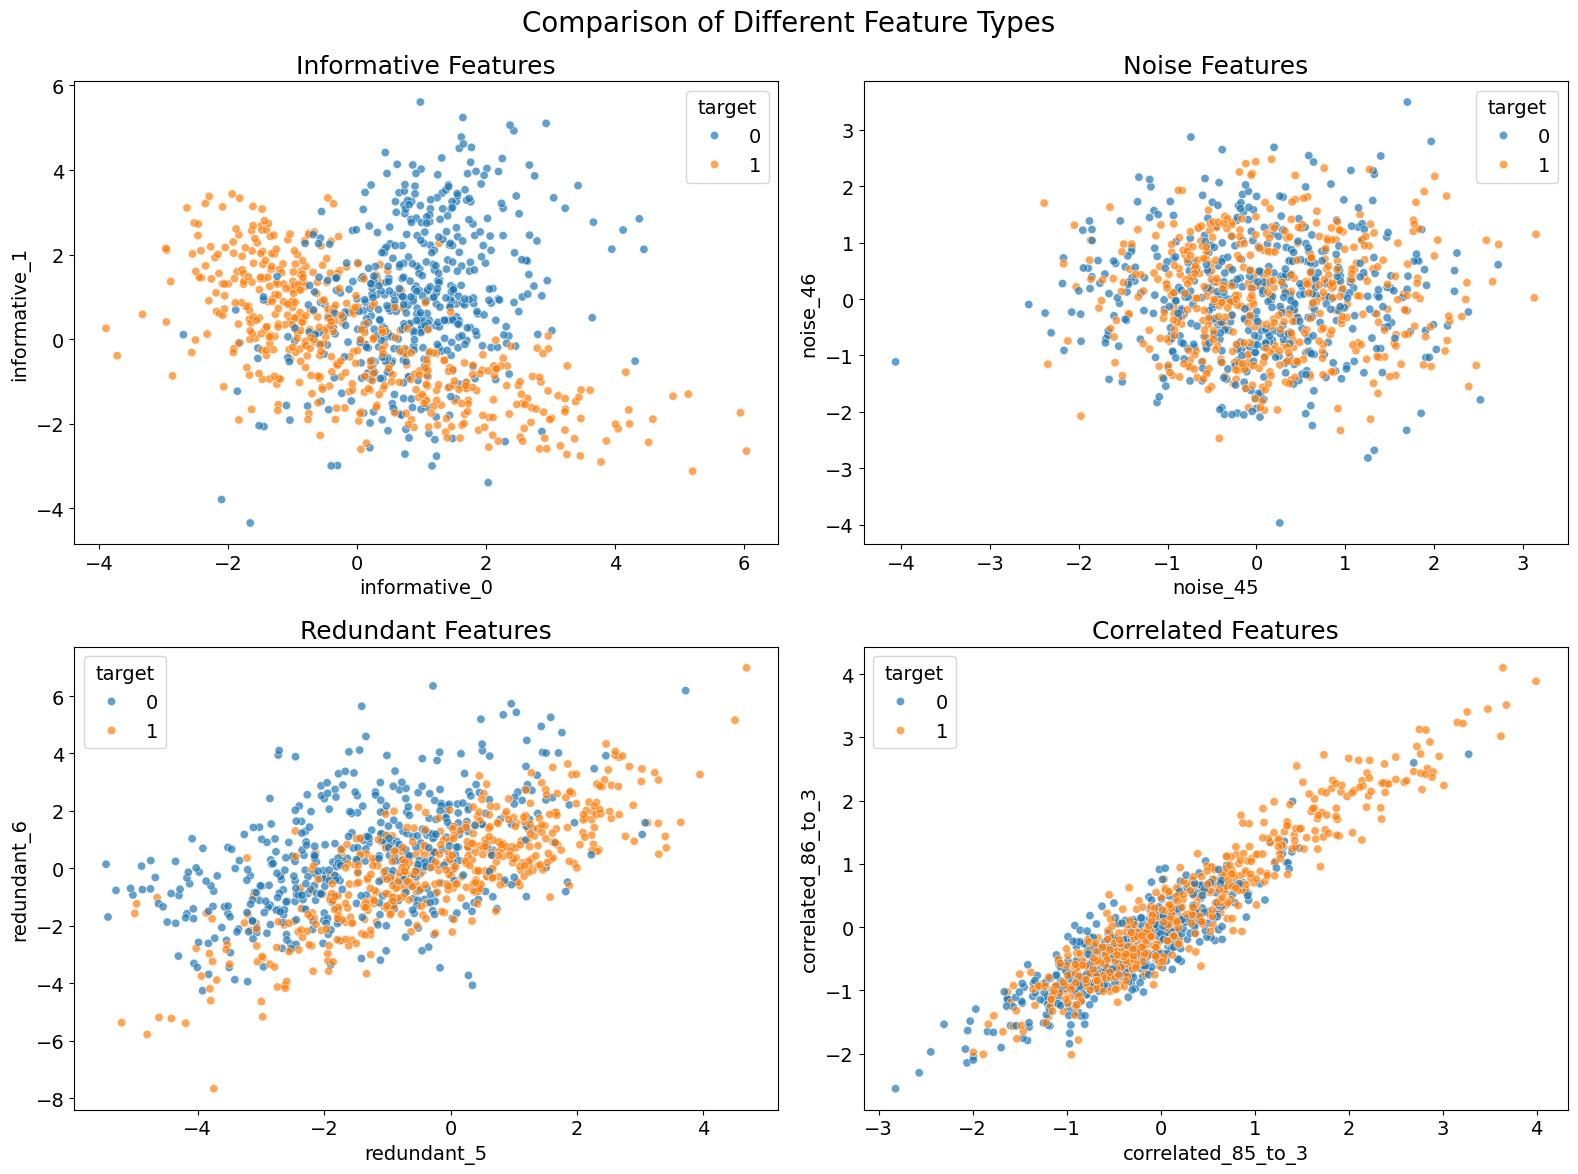

In [8]:
# Create 2x2 subplots to compare different feature types
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Informative/Relevant features (top left)
sns.scatterplot(
    x=X_full_df['informative_0'], 
    y=X_full_df['informative_1'], 
    hue=y_df, 
    alpha=0.7,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Informative Features', fontsize=18)
axes[0, 0].set_xlabel('informative_0')
axes[0, 0].set_ylabel('informative_1')

# 2. Noise features (top right)
sns.scatterplot(
    x=X_full_df['noise_45'], 
    y=X_full_df['noise_46'], 
    hue=y_df, 
    alpha=0.7,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Noise Features', fontsize=18)
axes[0, 1].set_xlabel('noise_45')
axes[0, 1].set_ylabel('noise_46')

# 3. Redundant features (bottom left)
sns.scatterplot(
    x=X_full_df['redundant_5'], 
    y=X_full_df['redundant_6'], 
    hue=y_df, 
    alpha=0.7,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Redundant Features', fontsize=18)
axes[1, 0].set_xlabel('redundant_5')
axes[1, 0].set_ylabel('redundant_6')

# Get names of the first two correlated features
corr_features = [col for col in X_full_df.columns if 'correlated_85' in col or 'correlated_86' in col][:2]

# 4. Correlated features (bottom right)
sns.scatterplot(
    x=X_full_df[corr_features[0]], 
    y=X_full_df[corr_features[1]], 
    hue=y_df, 
    alpha=0.7,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Correlated Features', fontsize=18)
axes[1, 1].set_xlabel(corr_features[0])
axes[1, 1].set_ylabel(corr_features[1])

# Add a main title for the entire figure
fig.suptitle('Comparison of Different Feature Types', fontsize=20, y=0.98)

# Improve spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Show the plot
plt.show()

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_24620\2690146163.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mutual_info', y='feature', data=mi_df, palette=colors, ax=axes[0])
C:\Users\Łukasz\AppData\Local\Temp\ipykernel_24620\2690146163.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='f_value', y='feature', data=f_df, palette=colors, ax=axes[1])


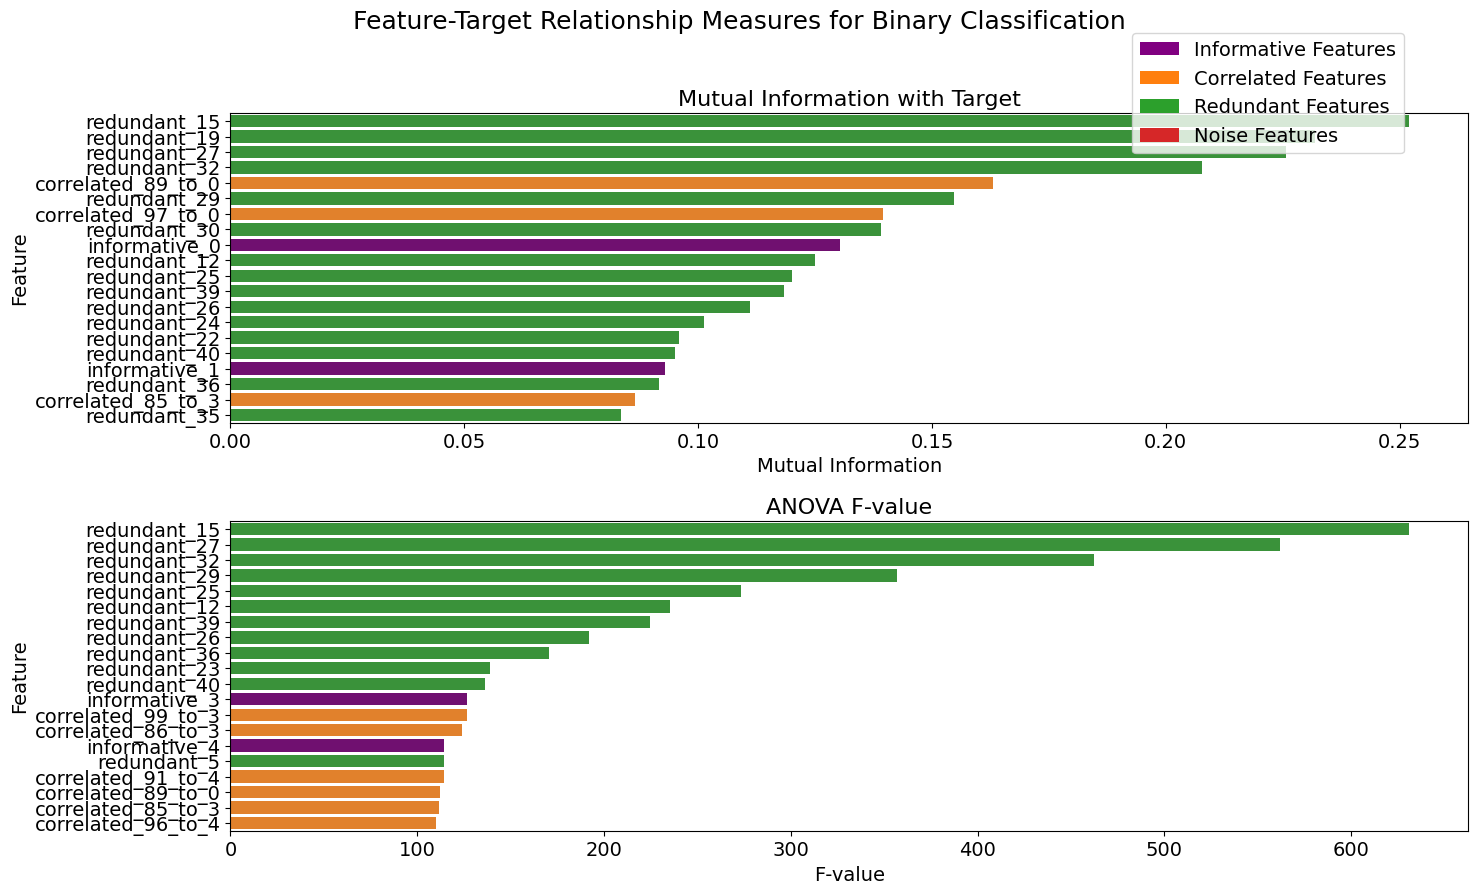


Top 10 features by Mutual Information:
1. redundant_15
2. redundant_19
3. redundant_27
4. redundant_32
5. correlated_89_to_0
6. redundant_29
7. correlated_97_to_0
8. redundant_30
9. informative_0
10. redundant_12

Top 10 features by ANOVA F-value:
1. redundant_15
2. redundant_27
3. redundant_32
4. redundant_29
5. redundant_25
6. redundant_12
7. redundant_39
8. redundant_26
9. redundant_36
10. redundant_23

Feature type distribution in top features:
Mutual Information: {'informative': 1, 'correlated': 2, 'redundant': 7, 'noise': 0}
ANOVA F-value: {'informative': 0, 'correlated': 0, 'redundant': 10, 'noise': 0}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy import stats

# Calculate different statistical measures for feature-target relationships
feature_stats = []
for col in X_full_df.columns:
    # Mutual Information (captures non-linear relationships)
    mi = mutual_info_classif(X_full_df[col].values.reshape(-1, 1), y_df, random_state=42)[0]
    
    # ANOVA F-value (measures class separability)
    f_val, _ = f_classif(X_full_df[col].values.reshape(-1, 1), y_df)
    
    feature_stats.append({
        'feature': col,
        'mutual_info': mi,
        'f_value': f_val[0]
    })

# Create dataframe with results
feature_stats_df = pd.DataFrame(feature_stats)

# Create color mapping for feature types
def assign_color(feature_name):
    if 'informative_' in feature_name:
        return 'purple'  # blue
    elif 'correlated_' in feature_name:
        return '#ff7f0e'  # orange
    elif 'redundant_' in feature_name:
        return '#2ca02c'  # green
    else:
        return '#d62728'  # red (noise)

# Create a figure with 3 subplots for each measurement
fig, axes = plt.subplots(2, 1, figsize=(15, 9))

# 2. Mutual Information
mi_df = feature_stats_df.sort_values('mutual_info', ascending=False).head(20)
colors = [assign_color(f) for f in mi_df['feature']]
sns.barplot(x='mutual_info', y='feature', data=mi_df, palette=colors, ax=axes[0])
axes[0].set_title('Mutual Information with Target', fontsize=16)
axes[0].set_xlabel('Mutual Information')
axes[0].set_ylabel('Feature')

# 3. ANOVA F-value
f_df = feature_stats_df.sort_values('f_value', ascending=False).head(20)
colors = [assign_color(f) for f in f_df['feature']]
sns.barplot(x='f_value', y='feature', data=f_df, palette=colors, ax=axes[1])
axes[1].set_title('ANOVA F-value', fontsize=16)
axes[1].set_xlabel('F-value')
axes[1].set_ylabel('Feature')

# Add legend to the figure
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', label='Informative Features'),
    Patch(facecolor='#ff7f0e', label='Correlated Features'),
    Patch(facecolor='#2ca02c', label='Redundant Features'),
    Patch(facecolor='#d62728', label='Noise Features')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.98))

plt.suptitle('Feature-Target Relationship Measures for Binary Classification', fontsize=18, y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Create a summary table comparing top features across different measures
top_n = 10
top_features = {
    'Mutual Information': feature_stats_df.sort_values('mutual_info', ascending=False)['feature'].head(top_n).tolist(),
    'ANOVA F-value': feature_stats_df.sort_values('f_value', ascending=False)['feature'].head(top_n).tolist()
}

# Display the top features for each measure
for measure, features in top_features.items():
    print(f"\nTop {top_n} features by {measure}:")
    for i, feature in enumerate(features, 1):
        print(f"{i}. {feature}")

# Count feature types in top ranks for each measure
def count_feature_types(feature_list):
    counts = {'informative': 0, 'correlated': 0, 'redundant': 0, 'noise': 0}
    for feature in feature_list:
        if 'informative_' in feature:
            counts['informative'] += 1
        elif 'correlated_' in feature:
            counts['correlated'] += 1
        elif 'redundant_' in feature:
            counts['redundant'] += 1
        else:
            counts['noise'] += 1
    return counts

print("\nFeature type distribution in top features:")
for measure, features in top_features.items():
    counts = count_feature_types(features)
    print(f"{measure}: {counts}")

# Saving

In [9]:
display(X_full_df.head())
# Save the dataset to a CSV file
output_file = 'synthetic_classification_dataset.csv'
X_full_df.to_csv(output_file, index=False)
print(f"Dataset saved to {output_file}")

# Save y_df to a separate CSV file
y_output_file = 'synthetic_classification_target.csv'
y_df.to_csv(y_output_file, index=False)

,informative_0,informative_1,informative_2,informative_3,informative_4,redundant_5,redundant_6,redundant_7,redundant_8,redundant_9,...,correlated_90_to_0,correlated_91_to_1,correlated_92_to_1,correlated_93_to_1,correlated_94_to_2,correlated_95_to_1,correlated_96_to_2,correlated_97_to_2,correlated_98_to_0,correlated_99_to_4
0,0.398925,0.300726,-1.242678,-2.660669,0.742052,-3.352542,-2.115725,2.355648,-0.416028,0.848956,...,0.028228,0.563031,0.194532,-0.309846,-0.604740,-0.122766,-0.847243,-0.665494,-0.074853,-0.004800
1,0.126402,-0.118903,1.683483,0.544816,1.466724,1.380566,1.910257,-1.051895,1.278274,-2.639946,...,0.967095,0.102137,0.582418,-0.608695,1.127434,-0.114151,1.673323,0.158308,0.061591,-0.721424
2,0.307531,1.477413,1.206126,-0.903038,0.553739,-1.292537,0.878660,-1.357008,-1.000782,-0.564504,...,-0.264608,0.320681,-0.735521,0.710122,0.842582,-0.445810,0.808114,0.648982,0.000397,-0.175790
3,1.078409,0.919532,0.589260,-1.545148,0.857398,-1.537698,0.705814,-0.326711,-0.074777,-1.166851,...,0.261691,0.189442,-0.386021,-0.102319,0.234078,-0.529107,0.683339,0.346187,0.355918,-0.260634
4,0.464995,3.919686,4.381151,-0.868213,-1.112734,-1.005722,3.929205,-5.457908,-4.013074,-0.742072,...,-0.531535,1.629324,-2.181841,2.002483,2.796442,-2.080199,2.797263,3.351613,-0.175372,1.002943


Dataset saved to synthetic_classification_dataset.csv
